## 기본 세팅
- 아래 코드 실행 후, 런타임 다시 시작

In [28]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
import lightgbm
lightgbm.__version__

'3.3.2'

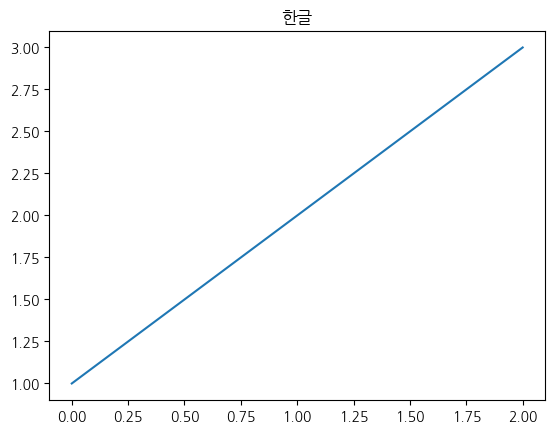

In [2]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

## 구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 0. 라이브러리 불러오기

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

## Step 1. 데이터 불러오기

In [5]:
bike_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ch05_data/bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [6]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


## Step 2. 데이터 가공 & EDA

In [7]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace=True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


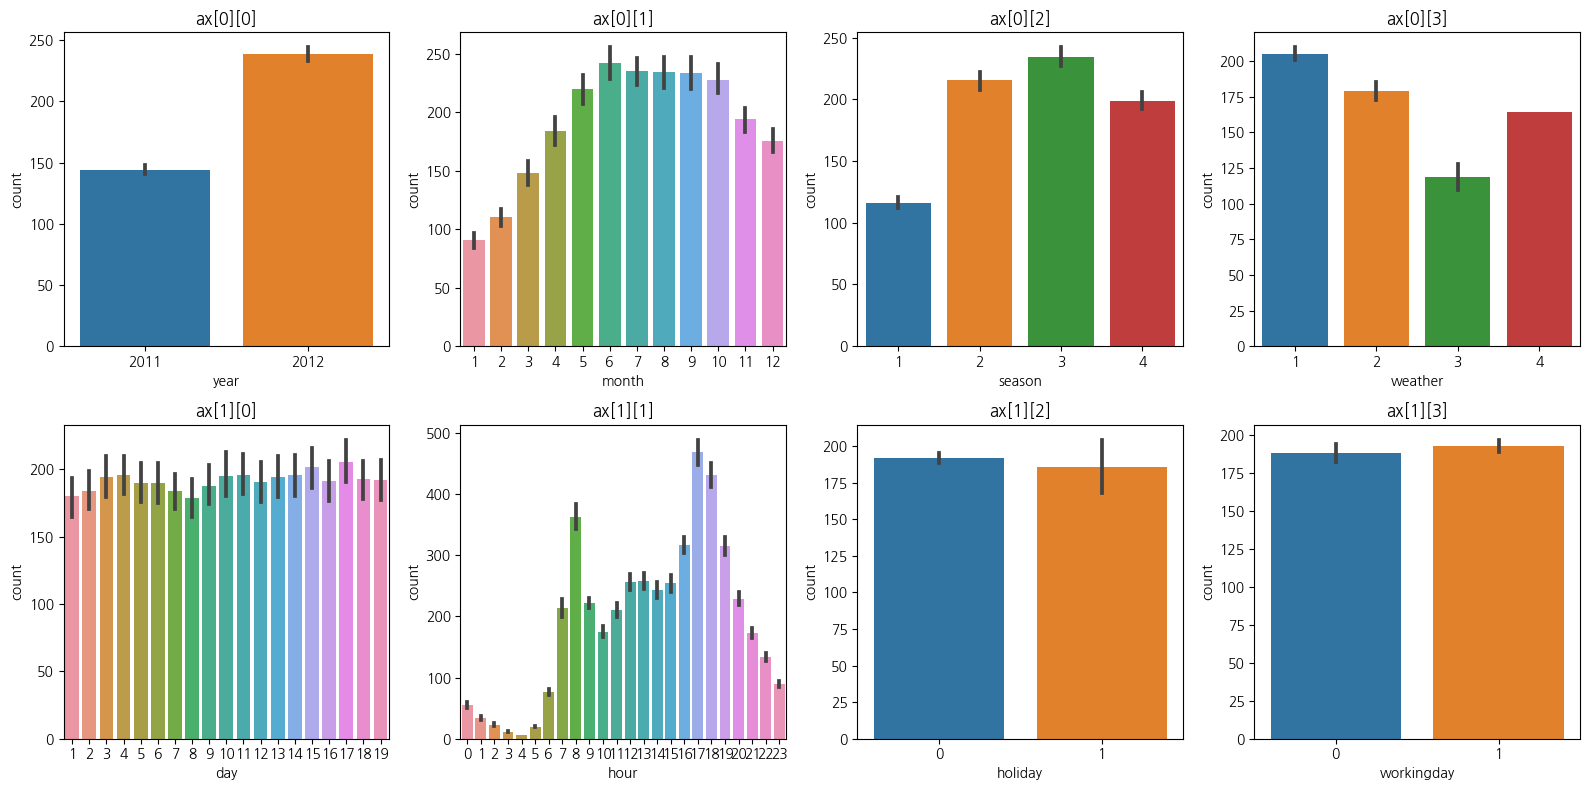

In [8]:
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
fig, ax = plt.subplots(figsize = (16, 8), ncols = 4, nrows = 2)
for i, feature in enumerate(cat_features):
  row = int(i/4) # 몫, 0과 1
  col = i%4      # 나머지 0, 1, 2, 3
  sns.barplot(x = feature, y = 'count', data = bike_df, ax = ax[row][col])
  ax[row][col].set_title(f"ax[{row}][{col}]")

plt.tight_layout()
plt.show()

## Step 3. 평가지표 구현
- RMSLE : scikit-learn에서는 미제공
- RMSLE 함수를 만듬

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN등의 이슈로 log() 사용안함, log1p() 사용함
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2 # 제곱
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# mean_squared_error() 이용해서 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## Step 4. 로그 변환, 피처 인코딩, 모델 학습

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 정규화, 표준화 작업 선 진행 해줘야 함
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7620, 12), (3266, 12), (7620,), (3266,))

In [11]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- p368 ~ p374 : 모델 성능 업그레이드를 하자!


## Step 5. 모델평가

In [12]:
def get_top_error_data(y_test, pred, n_tops = 5):
  result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

  # 예측값과 실제값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

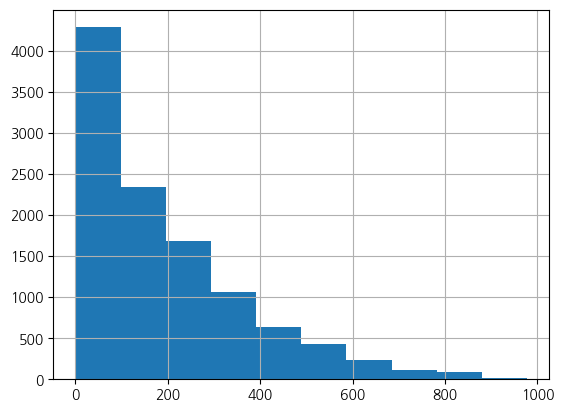

In [13]:
y_target.hist()

## Step 6. 종속변수 로그 변환

<Axes: >

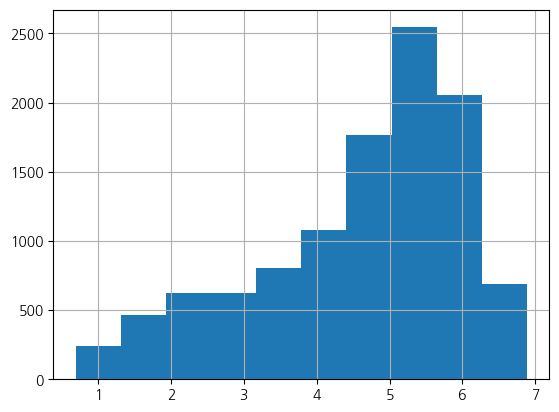

In [14]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

## Step 7. 모델 재구축

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 정규화, 표준화 작업 선 진행 해줘야 함
y_target_log = np.log1p(y_target)
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- 각 피처의 회귀 계수 값 시각화

<Axes: >

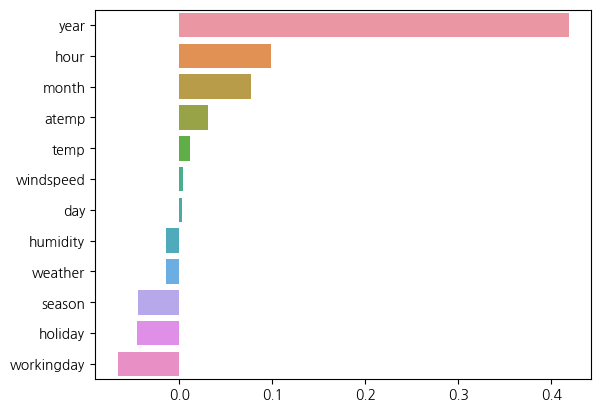

In [16]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## Step 8. 변수 인코딩 변환

In [17]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
# 원핫 인코딩 해줌
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

## Step 9. 모델 재구축 2
- 기존 인코딩 변환
- 3개의 모델을 비교 분석 하겠다!

In [18]:
# 테스트 / 훈련 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False) : # 지수변환
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1: # 지수변환 요청
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- 상위 20개 피처 찍어보기

<Axes: >

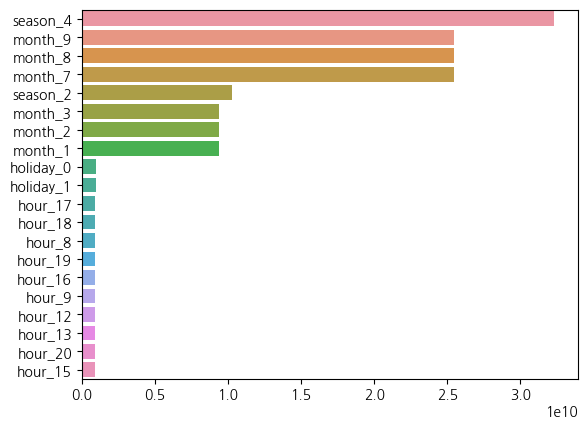

In [19]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

## Step 10 모델 재구축 3
- 다른 모델을 사용해서 진행을 해보자!

In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.373, MAE: 31.198
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.347, MAE: 32.746
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
